# This notebook test different algorithm using 3D coordiantes and object kind. 

<IPython.core.display.Javascript object>


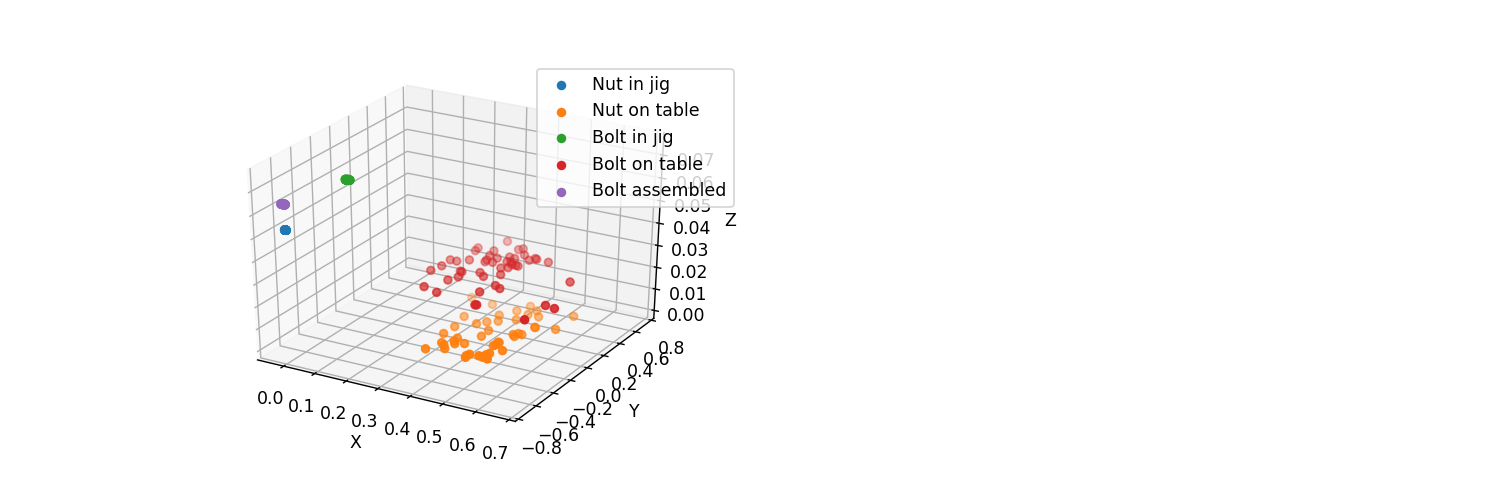

In [1]:
import numpy as np
%matplotlib notebook
import sys
sys.path.append('..')

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from utils.data import fetch_data, fetch_data_with_label, fetch_data_with_label_per_step, generate_data, label_to_int, divide_data
from utils.plotting import plot
from utils.clustering import agglomerative, kmeans, gaussian_mixture, Clustering
from sklearn.metrics import adjusted_rand_score

logfile_path = ['../data/raw/1599166289/data.pickle', '../data/raw/1599153598/data.pickle', '../data/raw/test/data.pickle']
# logfile_path = ['../data/raw/test/data.pickle']
#coordinates for nut and bolt
coord_nut, label_nut, coord_bolt, label_bolt = fetch_data_with_label(logfile_path)

label_concat = np.concatenate((label_nut, label_bolt))
label_nut_int = label_to_int(label_nut)
label_bolt_int = label_to_int(label_bolt)
label_concat_int = label_to_int(label_concat)

fig = plt.figure(1, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_nut, label_nut)
plot(ax, coord_bolt, label_bolt)


# Add noise

<IPython.core.display.Javascript object>


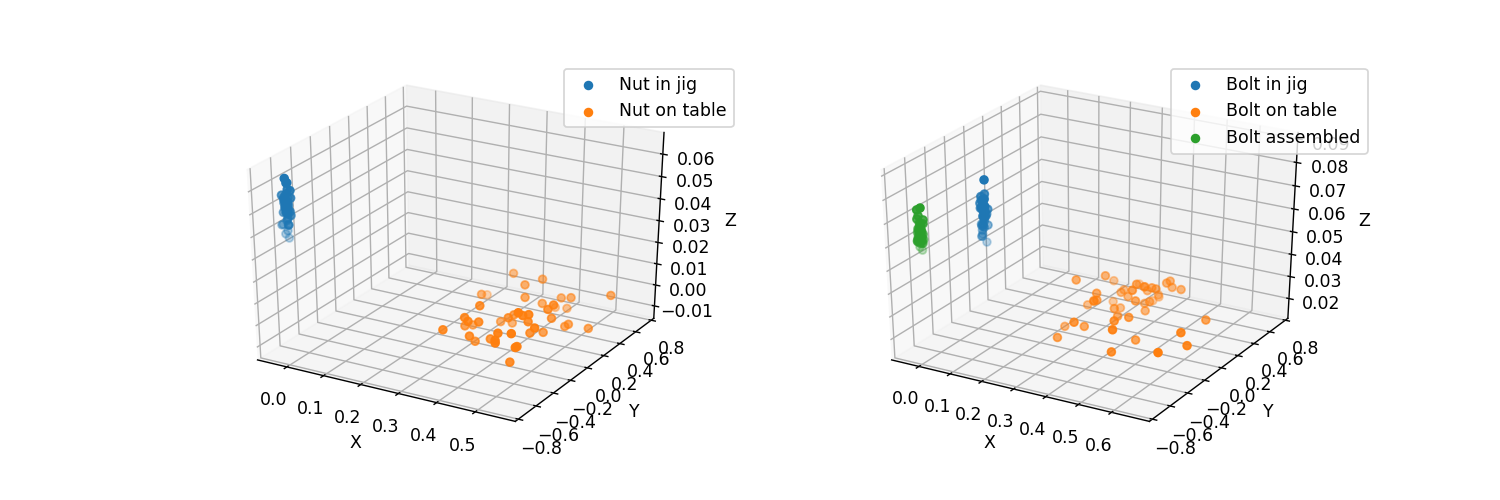

In [4]:
u = 0  # The average shift between the approximated coordinates and ground truth
sigma = 0.005
noise_nut = np.random.normal(u, sigma, coord_nut.shape)
noise_bolt = np.random.normal(u, sigma, coord_bolt.shape)

coord_nut_noisy = coord_nut + noise_nut
coord_bolt_noisy = coord_bolt + noise_bolt

fig = plt.figure(2, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_nut_noisy, label_nut)
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot(ax, coord_bolt_noisy, label_bolt)

# Agglomerative with P-nom and thres. Object kind is used as a hard constrain.

In [5]:
thres = 0.00995

estimated_label_nut = agglomerative(coord_nut_noisy, 'p_norm', thres)
estimated_label_bolt = agglomerative(coord_bolt_noisy, 'p_norm', thres)
estimated_label_concat = np.concatenate((estimated_label_nut, estimated_label_bolt + len(set(estimated_label_nut))))

In [6]:
print(max(estimated_label_nut), max(estimated_label_bolt))

1 2


<IPython.core.display.Javascript object>


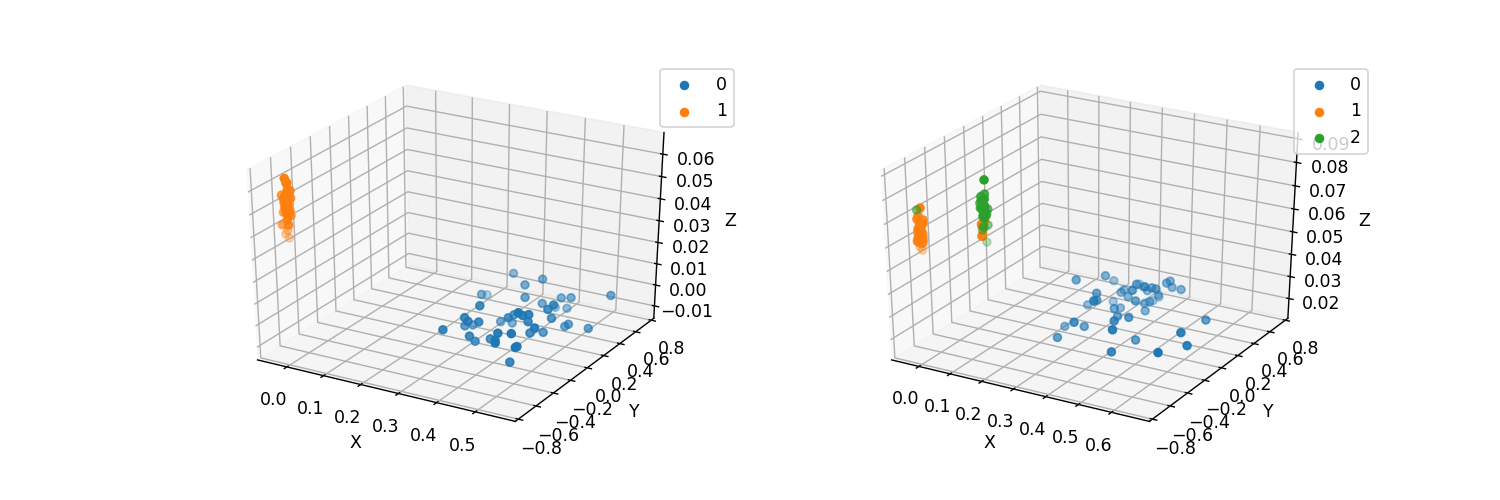

The accuracy for nut is 1.0
The accuracy for bolt is 0.8267058458151224
The accuracy for nut and bolt is 0.9120596348192921


In [7]:
fig = plt.figure(3, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_nut_noisy, estimated_label_nut)
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot(ax, coord_bolt_noisy, estimated_label_bolt)
print(f'The accuracy for nut is {adjusted_rand_score(estimated_label_nut, label_nut_int)}')
print(f'The accuracy for bolt is {adjusted_rand_score(estimated_label_bolt, label_bolt_int)}')
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_concat, label_concat_int)}')

In [8]:
n_test = 100
result = []
for i in np.linspace(0.005,0.015,100):
    accuracy = 0
    for j in range(n_test):
        thres = i
        u = 0  # The average shift between the approximated coordinates and ground truth
        sigma = 0.005
        noise_nut = np.random.normal(u, sigma, coord_nut.shape)
        noise_bolt = np.random.normal(u, sigma, coord_bolt.shape)

        coord_nut_noisy = coord_nut + noise_nut
        coord_bolt_noisy = coord_bolt + noise_bolt
        
        estimated_label_nut = agglomerative(coord_nut_noisy, 'p_norm', thres)
        estimated_label_bolt = agglomerative(coord_bolt_noisy, 'p_norm', thres)
        estimated_label_concat = np.concatenate((estimated_label_nut, estimated_label_bolt + len(set(estimated_label_nut))))
        accuracy += adjusted_rand_score(estimated_label_concat, label_concat_int)
    
    result.append(accuracy/n_test) 
        

KeyboardInterrupt: 

In [ ]:
ind = np.argmax(result)
np.linspace(0.005,0.015,100)[ind]

# Agglomerative with P-nom and thres. Object kind is used as a soft constrain.

In [9]:
n_nut = coord_nut_noisy.shape[0]
n_bolt = coord_bolt_noisy.shape[0]
kind_nut = np.zeros((n_nut, 2))
kind_nut[:,0] = 1 - np.random.normal(0.1, 0.05, n_nut)
kind_nut[:,1] = 1 - kind_nut[:,0]
kind_bolt = np.zeros((n_bolt, 2))
kind_bolt[:, 1] = 1 - np.random.normal(0.1, 0.05, n_bolt)
kind_bolt[:,0] = 1 - kind_bolt[:,1]

coord_nut_noisy_ext = np.concatenate((coord_nut_noisy, kind_nut), axis = 1)
coord_bolt_noisy_ext = np.concatenate((coord_bolt_noisy, kind_bolt), axis = 1)
coord_concat_ext = np.concatenate((coord_nut_noisy_ext, coord_bolt_noisy_ext))

In [11]:
thres = 0.01

estimated_label_concat = agglomerative(coord_concat_ext, 'p_norm', thres, p = -1.2)
max(estimated_label_concat)

5

<IPython.core.display.Javascript object>


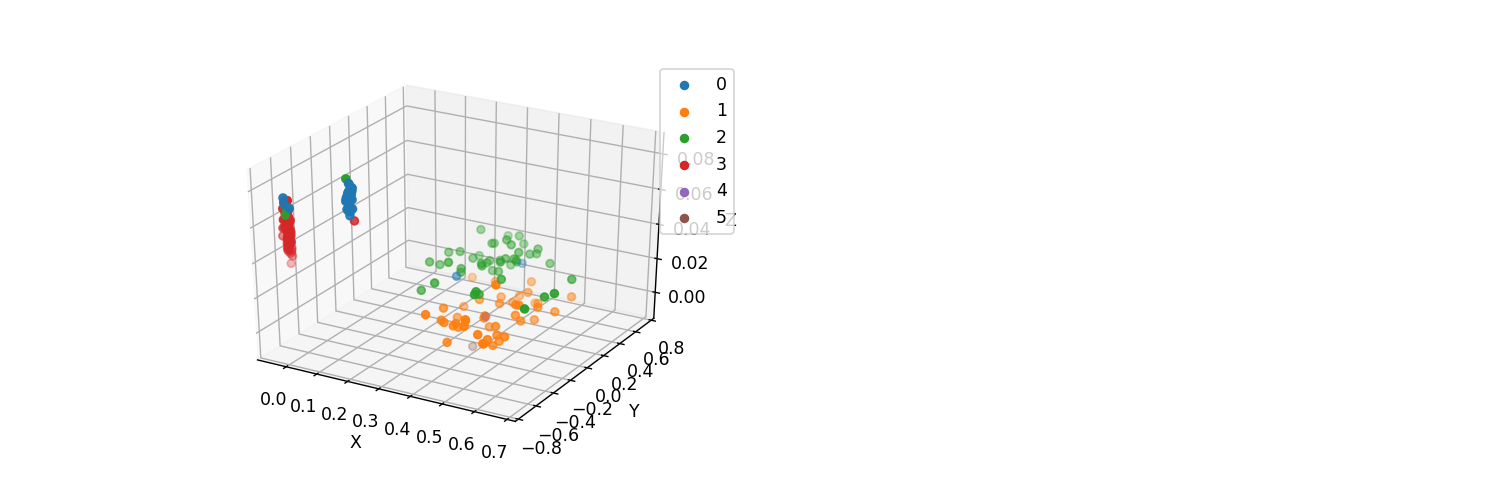

The accuracy for nut and bolt is 0.6840579020471532


In [12]:
fig = plt.figure(4, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_concat_ext, estimated_label_concat)
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_concat, label_concat_int)}')

# Agglomerative with P-nom and number of clusters. Object kind is used as a soft constrain.

In [13]:
estimated_label_concat = agg_clustering(coord_concat_ext, 'p_norm', thres = None, n_clusters = 5, p = -1.8)

<IPython.core.display.Javascript object>


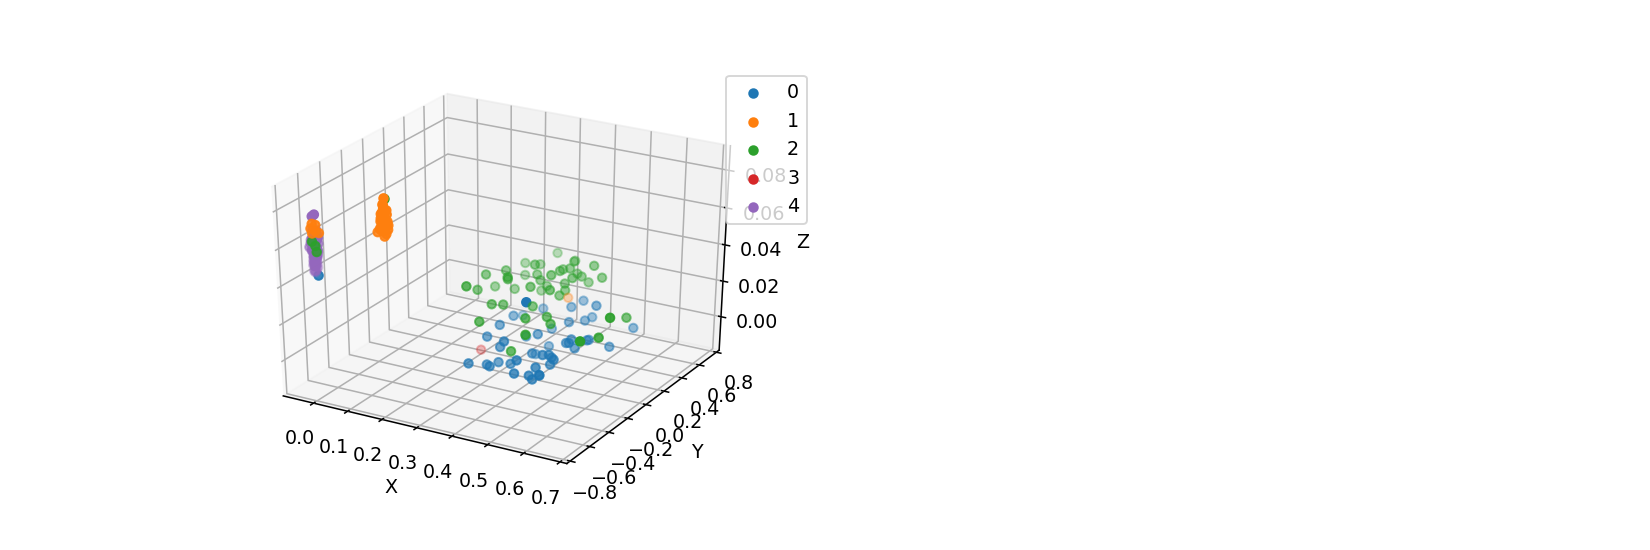

The accuracy for nut and bolt is 0.6952046548837151


In [14]:
fig = plt.figure(5, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_concat_ext, estimated_label_concat)
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_concat, label_concat_int)}')

In [3]:
n_test = 1000
score = 0
u = 0  # The average shift between the approximated coordinates and ground truth
sigma = 0.005
n_nut = coord_nut_noisy.shape[0]
n_bolt = coord_bolt_noisy.shape[0]
kind_nut = np.zeros((n_nut, 2))
kind_bolt = np.zeros((n_bolt, 2))
n_clusters = 5

for i in range(n_test):
    noise_nut = np.random.normal(u, sigma, coord_nut.shape)
    noise_bolt = np.random.normal(u, sigma, coord_bolt.shape)

    coord_nut_noisy = coord_nut + noise_nut
    coord_bolt_noisy = coord_bolt + noise_bolt

    kind_nut[:,0] = 1 - np.random.normal(0.1, 0.05, n_nut)
    kind_nut[:,1] = 1 - kind_nut[:,0]

    kind_bolt[:, 1] = 1 - np.random.normal(0.1, 0.05, n_bolt)
    kind_bolt[:,0] = 1 - kind_bolt[:,1]
    
    coord_nut_noisy_ext = np.concatenate((coord_nut_noisy, kind_nut), axis = 1)
    coord_bolt_noisy_ext = np.concatenate((coord_bolt_noisy, kind_bolt), axis = 1)
    coord_concat_ext = np.concatenate((coord_nut_noisy_ext, coord_bolt_noisy_ext))
    
    c = Clustering(coord_concat_ext, 'agglomerative', 'p_norm', n_clusters, thres = None)
    estimated_labels = c.predict()
    score += adjusted_rand_score(estimated_labels, label_concat_int)

print(score/n_test)

0.6415010889401717


# Agglomerative with Euclidean and number of clusters. Object kind is used as a soft constrain.

In [15]:
estimated_label_ext = agg_clustering(coord_concat_ext, 'euclidean', thres = None, n_clusters = 5)

<IPython.core.display.Javascript object>


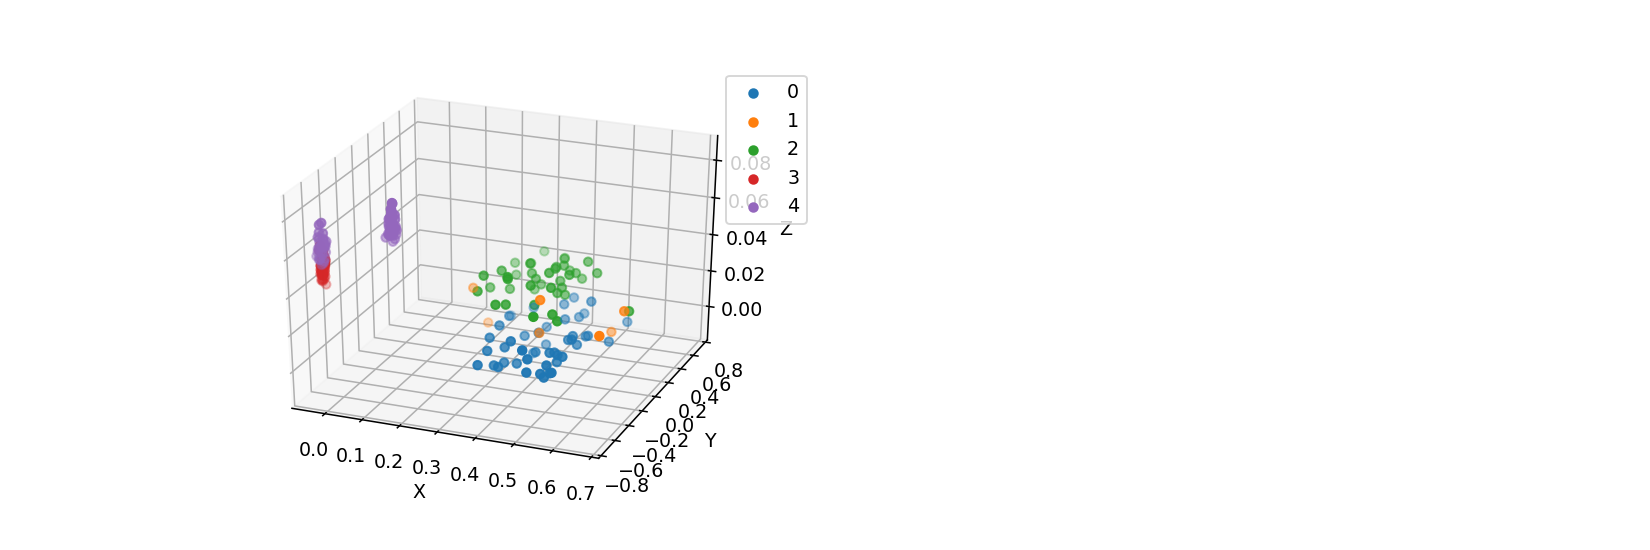

The accuracy for nut and bolt is 0.7607945216923008


In [16]:
fig = plt.figure(6, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_concat_ext, estimated_label_ext)
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_ext, label_concat_int)}')

In [4]:
n_test = 1000
score = 0
u = 0  # The average shift between the approximated coordinates and ground truth
sigma = 0.005
n_nut = coord_nut_noisy.shape[0]
n_bolt = coord_bolt_noisy.shape[0]
kind_nut = np.zeros((n_nut, 2))
kind_bolt = np.zeros((n_bolt, 2))
n_clusters = 5

for i in range(n_test):
    noise_nut = np.random.normal(u, sigma, coord_nut.shape)
    noise_bolt = np.random.normal(u, sigma, coord_bolt.shape)

    coord_nut_noisy = coord_nut + noise_nut
    coord_bolt_noisy = coord_bolt + noise_bolt

    kind_nut[:,0] = 1 - np.random.normal(0.1, 0.05, n_nut)
    kind_nut[:,1] = 1 - kind_nut[:,0]

    kind_bolt[:, 1] = 1 - np.random.normal(0.1, 0.05, n_bolt)
    kind_bolt[:,0] = 1 - kind_bolt[:,1]
    
    coord_nut_noisy_ext = np.concatenate((coord_nut_noisy, kind_nut), axis = 1)
    coord_bolt_noisy_ext = np.concatenate((coord_bolt_noisy, kind_bolt), axis = 1)
    coord_concat_ext = np.concatenate((coord_nut_noisy_ext, coord_bolt_noisy_ext))
    
    c = Clustering(coord_concat_ext, 'agglomerative', 'euclidean', n_clusters, thres = None)
    estimated_labels = c.predict()
    score += adjusted_rand_score(estimated_labels, label_concat_int)

print(score/n_test)

0.7472042473678663


# kmeans with p_norm and number of clusters. Object kind is used as a soft constrain.

In [13]:
n_clusters = 5
estimated_label_ext, centers = kmeans(coord_concat_ext, n_clusters, 'p_norm')

..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)


<IPython.core.display.Javascript object>


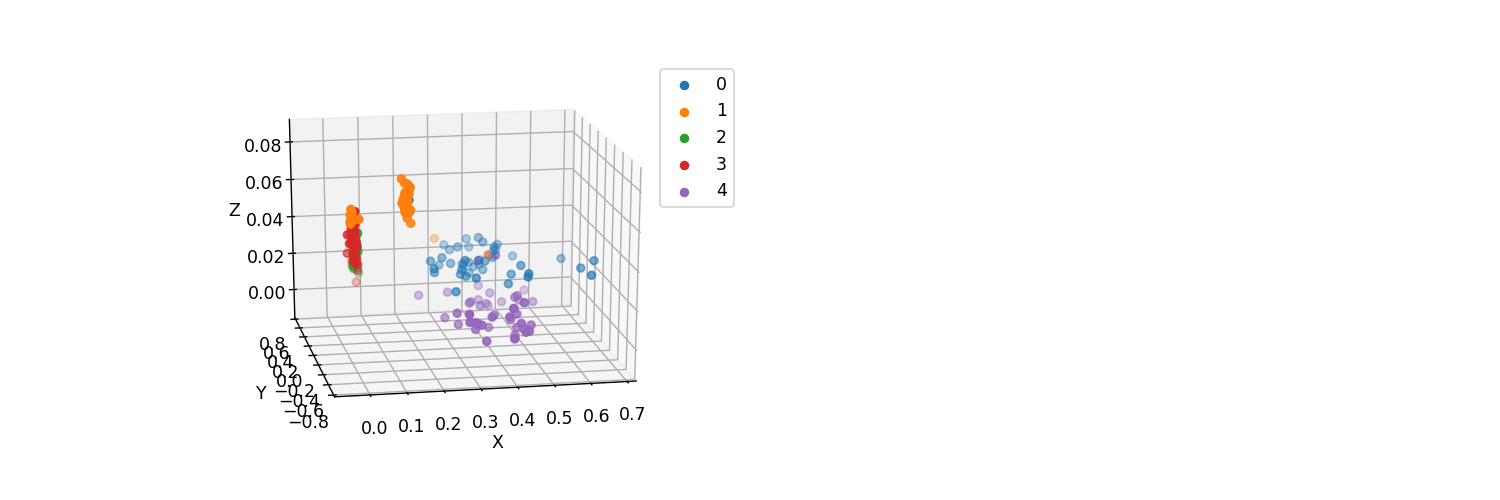

The accuracy for nut and bolt is 0.6455574968675455


In [14]:
fig = plt.figure(7, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_concat_ext, estimated_label_ext)
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_ext, label_concat_int)}')

In [6]:
n_test = 100
score = 0
u = 0  # The average shift between the approximated coordinates and ground truth
sigma = 0.005
n_nut = coord_nut_noisy.shape[0]
n_bolt = coord_bolt_noisy.shape[0]
kind_nut = np.zeros((n_nut, 2))
kind_bolt = np.zeros((n_bolt, 2))
n_clusters = 5

for i in range(n_test):
    noise_nut = np.random.normal(u, sigma, coord_nut.shape)
    noise_bolt = np.random.normal(u, sigma, coord_bolt.shape)

    coord_nut_noisy = coord_nut + noise_nut
    coord_bolt_noisy = coord_bolt + noise_bolt

    kind_nut[:,0] = 1 - np.random.normal(0.1, 0.05, n_nut)
    kind_nut[:,1] = 1 - kind_nut[:,0]

    kind_bolt[:, 1] = 1 - np.random.normal(0.1, 0.05, n_bolt)
    kind_bolt[:,0] = 1 - kind_bolt[:,1]
    
    coord_nut_noisy_ext = np.concatenate((coord_nut_noisy, kind_nut), axis = 1)
    coord_bolt_noisy_ext = np.concatenate((coord_bolt_noisy, kind_bolt), axis = 1)
    coord_concat_ext = np.concatenate((coord_nut_noisy_ext, coord_bolt_noisy_ext))
    
    c = Clustering(coord_concat_ext, 'kmeans', 'p_norm', n_clusters, thres = None)
    estimated_labels = c.predict()
    score += adjusted_rand_score(estimated_labels, label_concat_int)

print(score/n_test)

..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
C:\Users\xyao0\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\xyao0\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWa

..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[

0.6268992294719673


# kmeans with euclidean and number of clusters. Object kind is used as a soft constrain.

In [19]:
n_clusters = 5
estimated_label_ext, centers = kmeans(coord_concat_ext, n_clusters, 'euclidean')

<IPython.core.display.Javascript object>


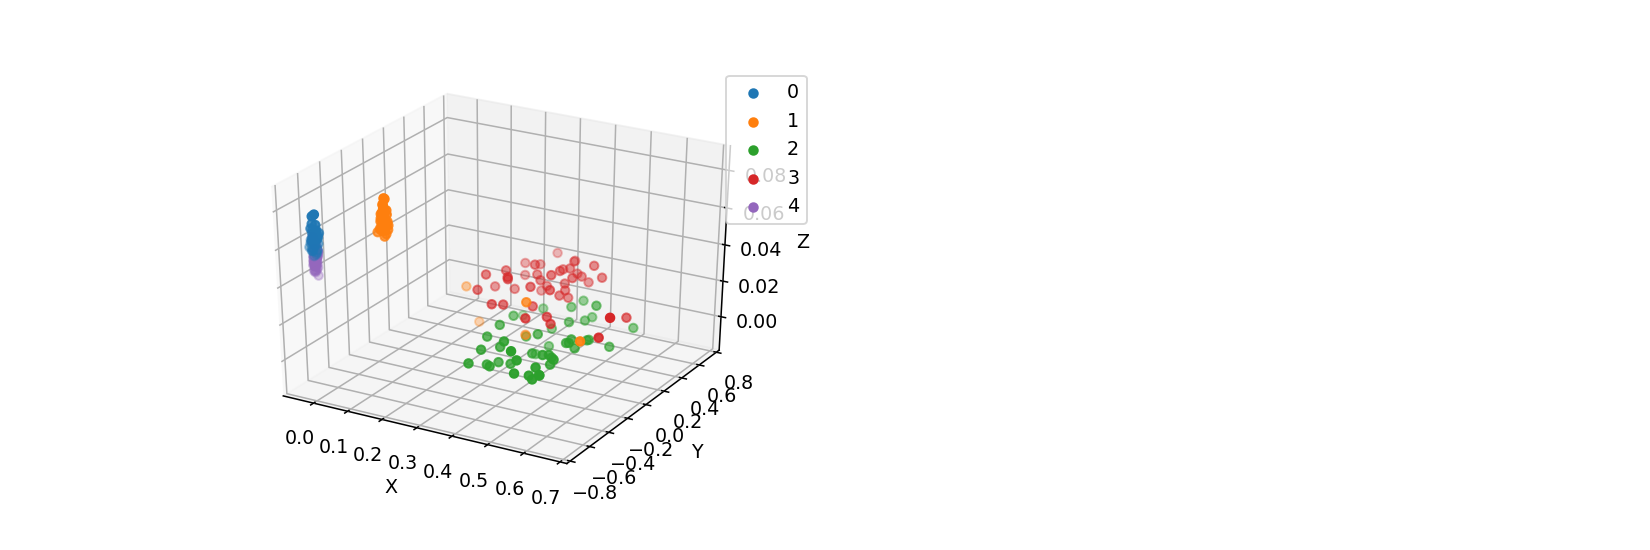

The accuracy for nut and bolt is 0.9452260880137452


In [20]:
fig = plt.figure(8, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_concat_ext, estimated_label_ext)
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_ext, label_concat_int)}')

# kmeans with cosine and number of clusters. Object kind is used as a soft constrain.

In [21]:
n_clusters = 5
estimated_label_ext, centers = kmeans(coord_concat_ext, n_clusters, 'cosine')

<IPython.core.display.Javascript object>


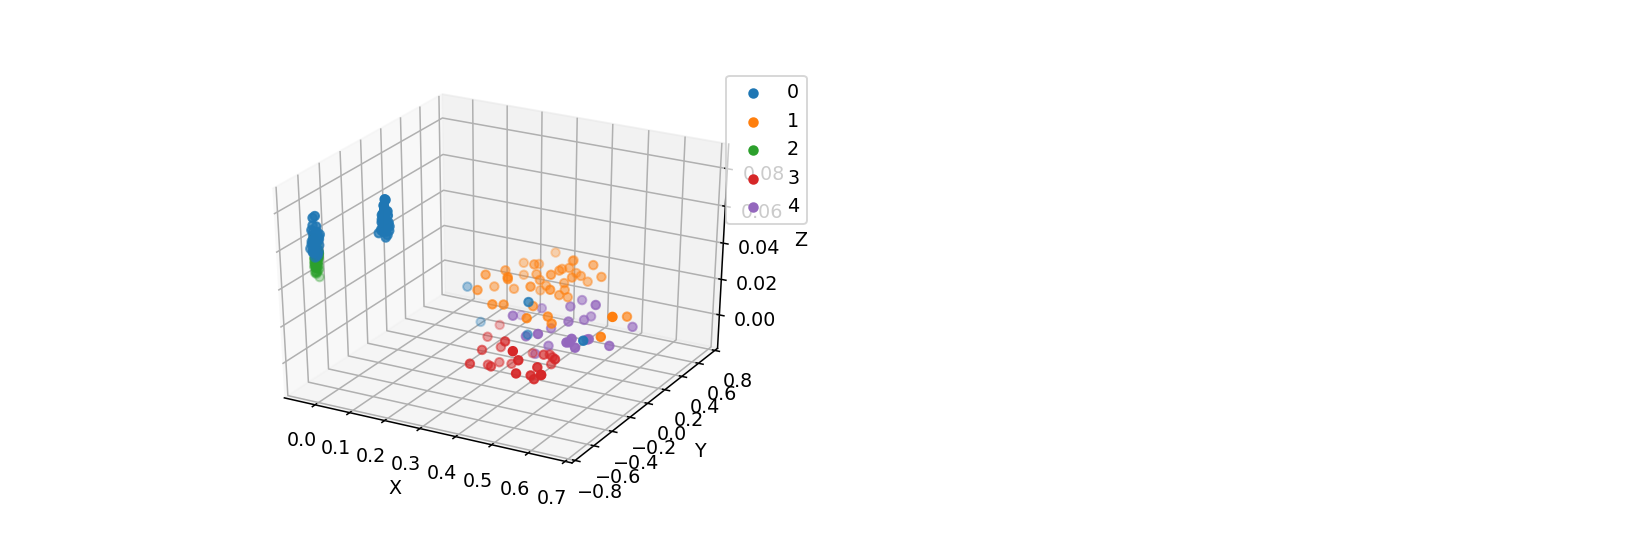

The accuracy for nut and bolt is 0.6622393902211183


In [22]:
fig = plt.figure(9, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_concat_ext, estimated_label_ext)
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_ext, label_concat_int)}')

# Gaussian mixture model

<IPython.core.display.Javascript object>


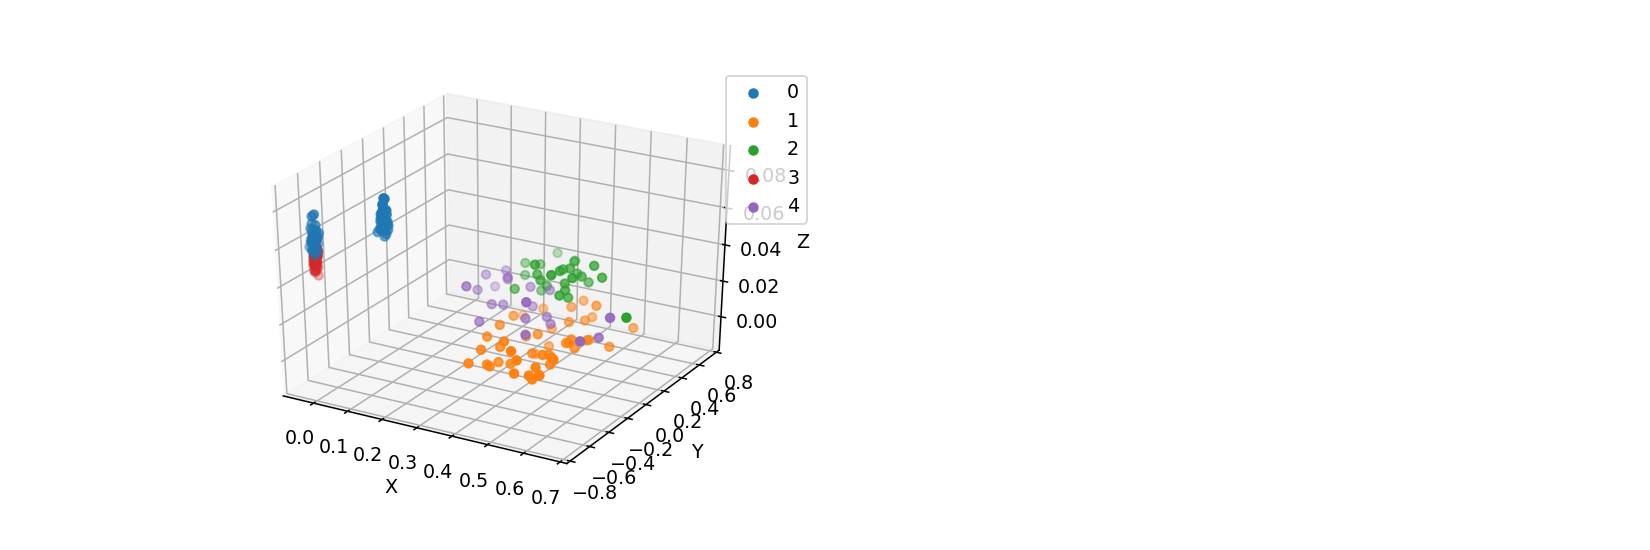

0.7248320215239574


In [23]:
estimated_label_ext, em = gaussian_mixture(coord_concat_ext, n_clusters)

fig = plt.figure(11, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_concat_ext, estimated_label_ext)
print(adjusted_rand_score(estimated_label_ext, label_concat_int))